## Prototypical Networks

The Prototypical Network, or ProtoNet for short, is a metric-based meta-learning algorithm that operates similarly to the nearest neighbor classification. Metric-based meta-learning methods classify a new example $\mathbf{x}$ based on some distance function $d_{\varphi}$ between $x$ and all elements in the support set. ProtoNets implements this idea with the concept of prototypes in a learned feature space. First, ProtoNet uses an embedding function $f_{\theta}$ to encode each input in the support set into a $L$-dimensional feature vector. Next, for each class $c$, we collect the feature vectors of all examples with label $c$ and average their feature vectors. Formally, we can define this as:

$$\mathbf{v}_c=\frac{1}{|S_c|}\sum_{(\mathbf{x}_i,y_i)\in S_c}f_{\theta}(\mathbf{x}_i)$$

where $S_c$ is the part of the support set $S$ for which $y_i=c$, and $\mathbf{v}_c$ represents the _prototype_ of class $c$. The prototype calculation is visualized below for a 2-dimensional feature space and 3 classes (Figure credit - [Snell et al.](https://arxiv.org/pdf/1703.05175.pdf)). The colored dots represent encoded support elements with the color-corresponding class labels, and the black dots next to the class label are the averaged prototypes.

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/protonet_classification.svg?raw=1" width="300px"></center>

Based on these prototypes, we want to classify a new example. Remember that since we want to learn the encoding function $f_{\theta}$, this classification must be differentiable, and hence, we need to define a probability distribution across classes. For this, we will make use of the distance function $d_{\varphi}$: the closer a new example $\mathbf{x}$ is to a prototype $\mathbf{v}_c$, the higher the probability for $\mathbf{x}$ belonging to class $c$. Formally, we can simply use a softmax over the distances of $\mathbf{x}$ to all class prototypes:

$$p(y=c\vert\mathbf{x})=\text{softmax}(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c))=\frac{\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_c)\right)}{\sum_{c'\in \mathcal{C}}\exp\left(-d_{\varphi}(f_{\theta}(\mathbf{x}), \mathbf{v}_{c'})\right)}$$

Note that the negative sign is necessary since we want to increase the probability for close-by vectors and have a low probability for distant vectors. We train the network $f_{\theta}$ based on the cross-entropy error of the training query set examples. Thereby, the gradient flows through both the prototypes $\mathbf{v}_c$ and the query set encodings $f_{\theta}(\mathbf{x})$. For the distance function $d_{\varphi}$, we can choose any function as long as it is differentiable concerning both of its inputs. The most common function, which we also use here, is the squared euclidean distance, but there have been several works on different distance functions as well.

## MAML and ProtoMAML

The second meta-learning algorithm we will look at is MAML, short for Model-Agnostic Meta-Learning. MAML is an optimization-based meta-learning algorithm, which means that it tries to adjust the standard optimization procedure to a few-shot setting. The idea of MAML is relatively simple: given a model, support, and query set during training, we optimize the model for $m$ steps on the support set and evaluate the gradients of the query loss with respect to the original model's parameters. For the same model, we do it for a few different support-query sets and accumulate the gradients. This results in learning a model that provides a good initialization for being quickly adapted to the training tasks. If we denote the model parameters with $\theta$, we can visualize the procedure as follows (Figure credit - [Finn et al.](http://proceedings.mlr.press/v70/finn17a.html)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/MAML_figure.svg?raw=1" width="300px"></center>

The full algorithm of MAML is therefore as follows. At each training step, we sample a batch of tasks, i.e., a batch of support-query set pairs. For each task $\mathcal{T}_i$, we optimize a model $f_{\theta}$ on the support set via SGD, and denote this model as $f_{\theta_i'}$. We refer to this optimization as _inner loop_. Using this new model, we calculate the gradients of the original parameters, $\theta$, with respect to the query loss on $f_{\theta_i'}$. These gradients are accumulated over all tasks and used to update $\theta$. This is called _outer loop_ since we iterate over tasks. The full MAML algorithm is summarized below (Figure credit - [Finn et al.](http://proceedings.mlr.press/v70/finn17a.html)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial16/MAML_algorithm.svg?raw=1" width="400px"></center>

To obtain gradients for the initial parameters $\theta$ from the optimized model $f_{\theta_i'}$, we actually need second-order gradients, i.e. gradients of gradients, as the support set gradients depend on $\theta$ as well. This makes MAML computationally expensive, especially when using multiple inner loop steps. A simpler, yet almost equally well-performing alternative is First-Order MAML (FOMAML) which only uses first-order gradients. This means that the second-order gradients are ignored, and we can calculate the outer loop gradients (line 10 in algorithm 2) simply by calculating the gradients with respect to $\theta_i'$ and use those as an update to $\theta$. Hence, the new update rule becomes:

$$
\theta\leftarrow\theta-\beta\sum_{\mathcal{T}_i\sim p(\mathcal{T})}\nabla_{\theta_i'}\mathcal{L}_{\mathcal{T}_i}(f_{\theta_i'})
$$

Note the change of $\theta$ to $\theta_i'$ for $\nabla$.

### ProtoMAML

A problem of MAML is how to design the output classification layer. In case all tasks have a different number of classes, we need to initialize the output layer with zeros or randomly in every iteration. Even if we always have the same number of classes, we just start from random predictions. This requires several inner loop steps to reach a reasonable classification result. To overcome this problem, Triantafillou et al. (2020) propose to combine the merits of Prototypical Networks and MAML. Specifically, we can use prototypes to initialize our output layer to have a strong initialization. Thereby, it can be shown that the softmax over euclidean distances can be reformulated as a linear layer with softmax. To see this, let's first write out the negative Euclidean distance between a feature vector $f_{\theta}(\mathbf{x}^{*})$ of a new data point $\mathbf{x}^{*}$ to a prototype $\mathbf{v}_c$ of class $c$:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})+2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c^T\mathbf{v}_c
$$

We perform the classification across all classes $c\in\mathcal{C}$ and take a softmax on the distance. Hence, any term that is the same for all classes can be removed without changing the output probabilities. In the equation above, this is true for $-f_{\theta}(\mathbf{x}^{*})^Tf_{\theta}(\mathbf{x}^{*})$ since it is independent of any class prototype. Thus, we can write:

$$
-||f_{\theta}(\mathbf{x}^{*})-\mathbf{v}_c||^2=2\mathbf{v}_c^{T}f_{\theta}(\mathbf{x}^{*})-||\mathbf{v}_c||^2+\text{constant}
$$

Taking a second look at the equation above, it looks a lot like a linear layer. For this, we use $\mathbf{W}_{c,\cdot}=2\mathbf{v}_c$ and $b_c=-||\mathbf{v}_c||^2$ which gives us the linear layer $\mathbf{W}f_{\theta}(\mathbf{x}^{*})+\mathbf{b}$. Hence, if we initialize the output weight with twice the prototypes, and the biases by the negative squared L2 norm of the prototypes, we start with a Prototypical Network. MAML allows us to adapt this layer and the rest of the network further.

In the following, we will implement First-Order ProtoMAML for few-shot classification. The implementation of MAML would be the same except for the output layer initialization.

### ProtoMAML implementation

For implementing ProtoMAML, we can follow Algorithm 2 with minor modifications. At each training step, we first sample a batch of tasks, and a support and query set for each task. In our case of few-shot classification, this means that we simply sample multiple support-query set pairs from our sampler. For each task, we finetune our current model on the support set. However, since we need to remember the original parameters for the other tasks, the outer loop gradient update, and future training steps, we need to create a copy of our model and finetune only the copy. We can copy a model by using standard Python functions like `deepcopy`. The inner loop is implemented in the function `adapt_few_shot` in the PyTorch Lightning module below.

After finetuning the model, we apply it to the query set and calculate the first-order gradients with respect to the original parameters $\theta$. In contrast to simple MAML, we also have to consider the gradients with respect to the output layer initialization, i.e. the prototypes, since they directly rely on $\theta$. To realize this efficiently, we take two steps. First, we calculate the prototypes by applying the original model, i.e. not the copied model, on the support elements. When initializing the output layer, we detach the prototypes to stop the gradients. This is because, in the inner loop itself, we do not want to consider gradients through the prototypes back to the original model. However, after the inner loop is finished, we re-attach the computation graph of the prototypes by writing `output_weight = (output_weight - init_weight).detach() + init_weight`. While this line does not change the value of the variable `output_weight`, it adds its dependency on the prototype initialization `init_weight`. Thus, if we call `.backward` on `output_weight`, we will automatically calculate the first-order gradients with respect to the prototype initialization in the original model.

After calculating all gradients and summing them together in the original model, we can take a standard optimizer step. PyTorch Lightning's method is however designed to return a loss-tensor on which we call `.backward` first. Since this is not possible here, we need to perform the optimization step ourselves. All details can be found in the code below.

For implementing (Proto-)MAML with second-order gradients, it is recommended to use libraries such as [$\nabla$higher](https://github.com/facebookresearch/higher) from Facebook AI Research.


In [1]:
!git clone https://github.com/learnables/learn2learn.git
%cd learn2learn
!pip install -e .

Cloning into 'learn2learn'...
remote: Enumerating objects: 4881, done.
remote: Counting objects: 100% (1221/1221), done.
remote: Compressing objects: 100% (307/307), done.
remote: Total 4881 (delta 1041), reused 914 (delta 914), pack-reused 3660 (from 1)
Receiving objects: 100% (4881/4881), 9.46 MiB | 18.82 MiB/s, done.
Resolving deltas: 100% (2834/2834), done.
/content/learn2learn
Obtaining file:///content/learn2learn
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━

In [1]:
!pip install learn2learn

In [2]:
import argparse
import random

import numpy as np
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST

import learn2learn as l2l

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

##  Model-Agnostic Meta-Learning

### Простая сеть

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, ways=3):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.bn2 = nn.BatchNorm2d(50)
        self.fc1 = nn.Linear(50*2*2, 500)
        self.fc2 = nn.Linear(500, ways)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2, 2)
        x = F.avg_pool2d(x, 2)
        x = x.view(-1, 50*2*2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)



In [4]:
def accuracy(predictions, targets, tolerance=0.05):
    #Берём индекс с максимальным логитом
    preds = predictions.argmax(dim=1).float()
    targets = targets.float()

    range_targets = targets.max() - targets.min()
    tol_value = tolerance * (range_targets + 1e-8)

    #Считаем, сколько предсказаний в пределах tolerance
    correct = (torch.abs(preds - targets) <= tol_value).sum(dtype=torch.float32)

    acc = correct / targets.numel()
    return acc.item()

In [15]:
import random
import numpy as np
import torch

ways = 5
shots = 1
tasks_per_step = 32 #tps
fast_adapt_steps = 5 #fas

iterations = 200

lr = 0.005
maml_lr = 0.01

device = torch.device("cpu")
download_location = 'data'

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if device.type == "cuda":
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Using device: {device}")
print(f"Ways: {ways}, Shots: {shots}, Tasks per step: {tasks_per_step}, Fast adaption steps: {fast_adapt_steps}")
print(f"Iterations: {iterations}, LR: {lr}, MAML LR: {maml_lr}")
print(f"Download location: {download_location}")


Using device: cpu
Ways: 5, Shots: 1, Tasks per step: 32, Fast adaption steps: 5
Iterations: 200, LR: 0.005, MAML LR: 0.01
Download location: data


In [6]:
import matplotlib.pyplot as plt

def visualize_task(taskset, ways, shots):
    task = taskset.sample()
    data, labels = task

    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(shots * ways) * 2] = True
    evaluation_indices = ~adaptation_indices

    support_data = data[adaptation_indices]
    support_labels = labels[adaptation_indices]

    query_data = data[evaluation_indices]
    query_labels = labels[evaluation_indices]

    fig, axes = plt.subplots(2, max(len(support_data), len(query_data)),
                             figsize=(12, 4))

    for i in range(len(support_data)):
        axes[0, i].imshow(support_data[i].squeeze(), cmap='gray')
        axes[0, i].set_title(f"S: {support_labels[i].item()}")
        axes[0, i].axis('off')

    for i in range(len(query_data)):
        axes[1, i].imshow(query_data[i].squeeze(), cmap='gray')
        axes[1, i].set_title(f"Q: {query_labels[i].item()}")
        axes[1, i].axis('off')

    axes[0, 0].set_ylabel("Support", fontsize=12)
    axes[1, 0].set_ylabel("Query", fontsize=12)

    plt.tight_layout()
    plt.show()


In [7]:
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    lambda x: x.view(1, 28, 28),
])

mnist_train = l2l.data.MetaDataset(MNIST(download_location,
                                         train=True,
                                         download=True,
                                         transform=transformations))
train_tasks = l2l.data.Taskset(
    mnist_train,
    task_transforms=[
        l2l.data.transforms.NWays(mnist_train, ways),
        l2l.data.transforms.KShots(mnist_train, 2*shots),
        l2l.data.transforms.LoadData(mnist_train),
        l2l.data.transforms.RemapLabels(mnist_train),
        l2l.data.transforms.ConsecutiveLabels(mnist_train),
    ],
    num_tasks=1000,
)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.43MB/s]


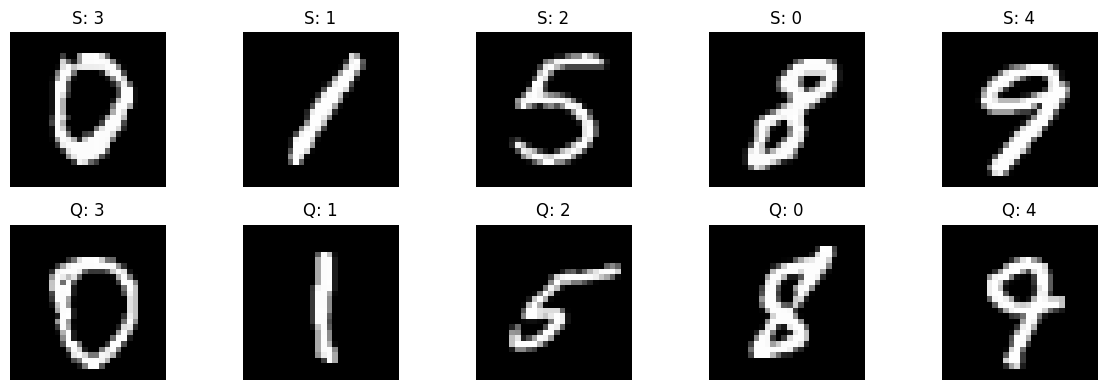

In [8]:
visualize_task(train_tasks, ways, shots)

In [16]:
import csv

#Модели и оптимизаторы
model = Net(ways).to(device) #архитектура для MAML
meta_model = l2l.algorithms.MAML(model, lr=maml_lr)
opt = optim.Adam(meta_model.parameters(), lr=lr)
loss_func = nn.NLLLoss(reduction='mean')

#baseline: такая же архитектура, но обычный PyTorch model (без MAML)
baseline_model = Net(ways).to(device)
baseline_opt = optim.Adam(baseline_model.parameters(), lr=lr)

# ------------------ CSV ЛОГИ ------------------
meta_csv = open("meta_metrics.csv", "w", newline="")
base_csv = open("baseline_metrics.csv", "w", newline="")

meta_writer = csv.writer(meta_csv)
base_writer = csv.writer(base_csv)

meta_writer.writerow(["iteration", "loss", "accuracy"])
base_writer.writerow(["iteration", "loss", "accuracy"])
# ---------------------------------------------

for iteration in range(iterations):
    iteration_error = 0.0 #для meta
    iteration_acc = 0.0

    baseline_iteration_error = 0.0 #для baseline
    baseline_iteration_acc = 0.0

    for _ in range(tasks_per_step):
        #подготовка эпизода -----------------------
        learner = meta_model.clone() #для MAML
        train_task = train_tasks.sample()
        data, labels = train_task
        data = data.to(device)
        labels = labels.to(device)

        adaptation_indices = np.zeros(data.size(0), dtype=bool)
        adaptation_indices[np.arange(shots*ways) * 2] = True
        evaluation_indices = torch.from_numpy(~adaptation_indices)
        adaptation_indices = torch.from_numpy(adaptation_indices)

        adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
        evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]

        #MAML: fast adaptation на support set
        for step in range(fast_adapt_steps):
            train_error = loss_func(learner(adaptation_data), adaptation_labels)
            learner.adapt(train_error)

        #Compute validation loss (meta)
        predictions = learner(evaluation_data)
        valid_error = loss_func(predictions, evaluation_labels)
        valid_accuracy = accuracy(predictions, evaluation_labels)
        iteration_error += valid_error
        iteration_acc += valid_accuracy

        #Baseline: один градиентный шаг на adaptation_data, затем оценка на evaluation_data
        baseline_opt.zero_grad()
        baseline_preds_train = baseline_model(adaptation_data)
        baseline_train_loss = loss_func(baseline_preds_train, adaptation_labels)
        baseline_train_loss.backward()
        baseline_opt.step()

        #Оценка baseline на evaluation set
        baseline_preds_eval = baseline_model(evaluation_data)
        baseline_valid_loss = loss_func(baseline_preds_eval, evaluation_labels)
        baseline_valid_acc = accuracy(baseline_preds_eval, evaluation_labels)

        baseline_iteration_error += baseline_valid_loss
        baseline_iteration_acc += baseline_valid_acc

    #Усредняем по задачам в шаге
    iteration_error /= tasks_per_step
    iteration_acc /= tasks_per_step

    baseline_iteration_error /= tasks_per_step
    baseline_iteration_acc /= tasks_per_step

    print('Iter {:04d} | Loss Meta: {:.3f} Base: {:.3f} | Meta: {:.3f} Base: {:.3f}'.format(
      iteration,
      iteration_error.item(),  baseline_iteration_error.item(),
      iteration_acc, baseline_iteration_acc
    ))

    # -------- запись в CSV --------
    meta_writer.writerow([
        iteration,
        iteration_error.item(),
        iteration_acc
    ])

    base_writer.writerow([
        iteration,
        baseline_iteration_error.item(),
        baseline_iteration_acc
    ])
    # ------------------------------

    opt.zero_grad()
    iteration_error.backward()
    opt.step()

meta_csv.close()
base_csv.close()


Iter 0000 | Loss Meta: 1.553 Base: 1.676 | Meta: 0.419 Base: 0.231
Iter 0001 | Loss Meta: 1.529 Base: 1.634 | Meta: 0.331 Base: 0.181
Iter 0002 | Loss Meta: 1.503 Base: 1.646 | Meta: 0.325 Base: 0.181
Iter 0003 | Loss Meta: 1.519 Base: 1.625 | Meta: 0.337 Base: 0.206
Iter 0004 | Loss Meta: 1.422 Base: 1.602 | Meta: 0.406 Base: 0.262
Iter 0005 | Loss Meta: 1.422 Base: 1.607 | Meta: 0.381 Base: 0.206
Iter 0006 | Loss Meta: 1.294 Base: 1.616 | Meta: 0.513 Base: 0.194
Iter 0007 | Loss Meta: 1.278 Base: 1.615 | Meta: 0.488 Base: 0.188
Iter 0008 | Loss Meta: 1.225 Base: 1.629 | Meta: 0.550 Base: 0.212
Iter 0009 | Loss Meta: 1.116 Base: 1.618 | Meta: 0.575 Base: 0.219
Iter 0010 | Loss Meta: 1.252 Base: 1.630 | Meta: 0.500 Base: 0.175
Iter 0011 | Loss Meta: 1.056 Base: 1.613 | Meta: 0.650 Base: 0.212
Iter 0012 | Loss Meta: 1.128 Base: 1.613 | Meta: 0.644 Base: 0.169
Iter 0013 | Loss Meta: 1.020 Base: 1.623 | Meta: 0.638 Base: 0.175
Iter 0014 | Loss Meta: 1.045 Base: 1.615 | Meta: 0.625 Base: 0

### Динамика

In [17]:
import pandas as pd

df_baseline = pd.read_csv("/content/baseline_metrics.csv")
df_baseline["accuracy"] = df_baseline["accuracy"].str.replace("tensor\\(|\\)", "", regex=True).astype(float)
df_baseline.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,iteration,loss,accuracy
0,0,1.675616,0.2312
1,1,1.634047,0.1813
2,2,1.646010,0.1813
3,3,1.625334,0.2062
4,4,1.601985,0.2625


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [18]:
df_meta = pd.read_csv("/content/meta_metrics.csv")
df_meta["accuracy"] = df_meta["accuracy"].str.replace("tensor\\(|\\)", "", regex=True).astype(float)
df_meta.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,iteration,loss,accuracy
0,0,1.552951,0.4187
1,1,1.528697,0.3312
2,2,1.503394,0.3250
3,3,1.518869,0.3375
4,4,1.422046,0.4062


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


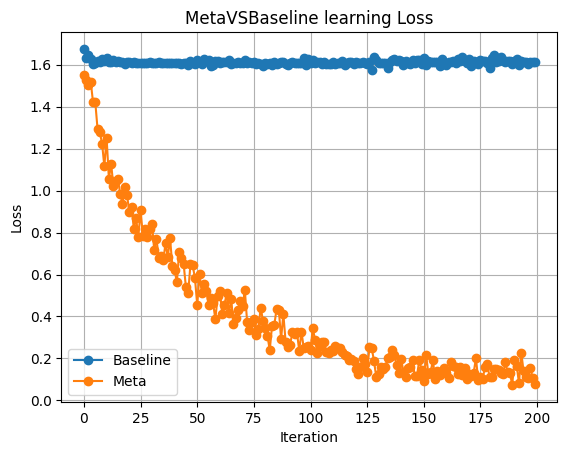

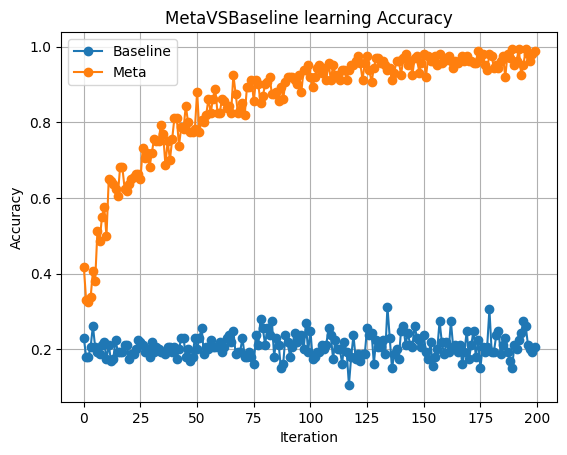

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_baseline["iteration"], df_baseline["loss"], marker='o', label="Baseline")
plt.plot(df_meta["iteration"], df_meta["loss"], marker='o', label="Meta")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MetaVSBaseline learning Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(df_baseline["iteration"], df_baseline["accuracy"], marker='o', label="Baseline")
plt.plot(df_meta["iteration"], df_meta["accuracy"], marker='o', label="Meta")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("MetaVSBaseline learning Accuracy")
plt.grid(True)
plt.legend()
plt.show()

Различия на графиках очевидны, без MAML градиетный спуск простобы стопорился на месте.

## Proto-Learning

In [20]:
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 8.2 MB/s eta 0:00:00


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import learn2learn as l2l
import numpy as np
import csv
from torchvision import transforms as T
from medmnist import DermaMNIST
from medmnist.info import INFO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
img_size = 28
ways = 7
shots = 10  #K-shot (увеличено для стабильности ProtoNet)
queries = 10 #Количество примеров query на класс для оценки и loss
tasks_per_step = 6
iterations = 200
lr = 1e-4
batch_size = 32
num_workers = 2
embedding_dim = 64

In [50]:
transform = T.Compose([
    T.Resize((img_size, img_size)),
    T.ToTensor(),
])

info = INFO['dermamnist']
DataClass = DermaMNIST

train_ds = DataClass(split='train', transform=transform, download=True)
val_ds   = DataClass(split='val',   transform=transform, download=True)
test_ds  = DataClass(split='test',  transform=transform, download=True)

meta_train = l2l.data.MetaDataset(train_ds)
meta_val   = l2l.data.MetaDataset(val_ds)

train_transforms = [
    l2l.data.transforms.NWays(meta_train, ways),
    l2l.data.transforms.KShots(meta_train, shots + queries),
    l2l.data.transforms.LoadData(meta_train),
    l2l.data.transforms.RemapLabels(meta_train),
]
train_tasks = l2l.data.Taskset(meta_train, task_transforms=train_transforms)

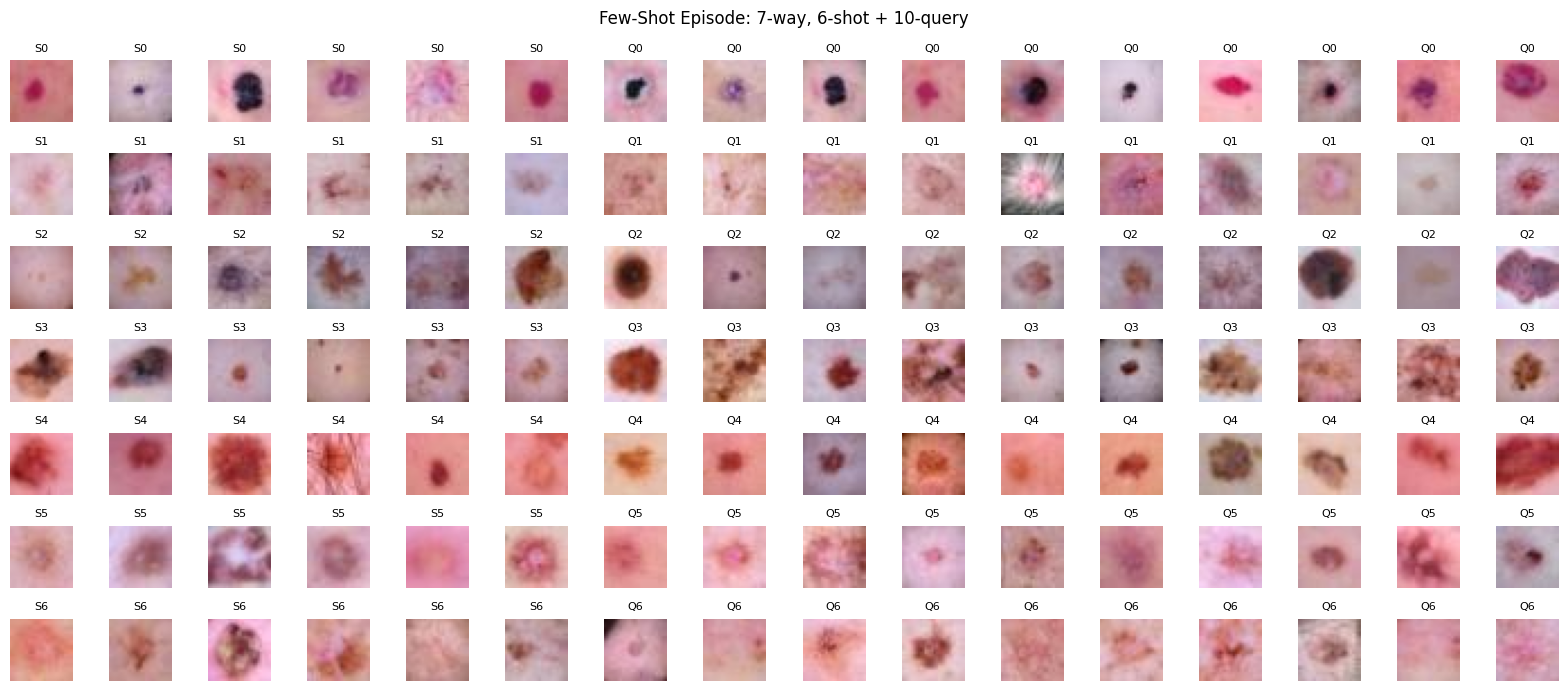

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_episode(task, ways, shots, queries):
    data, labels = task
    data = data.squeeze(0)
    labels = labels.squeeze(0)

    fig, axes = plt.subplots(ways, shots + queries, figsize=(shots + queries, ways))
    fig.suptitle("Few-Shot Episode: {}-way, {}-shot + {}-query".format(ways, shots, queries))

    for c in range(ways):
        cls_idx = (labels == c).nonzero(as_tuple=True)[0].cpu().numpy()
        images = data[cls_idx]
        for i in range(shots + queries):
            ax = axes[c, i] if ways > 1 else axes[i]
            img = images[i].permute(1, 2, 0).cpu().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if i < shots:
                ax.set_title(f"S{c}", fontsize=8)
            else:
                ax.set_title(f"Q{c}", fontsize=8)
    plt.tight_layout()
    plt.show()

episode = train_tasks.sample()
show_episode(episode, ways=ways, shots=6, queries=queries)

### Простая сеть

In [51]:
class Net(nn.Module):
    def __init__(self, embedding_dim=64):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.fc = nn.Linear(64 * 14 * 14, embedding_dim)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### Обучение

ProtoNet вспомогательные функции

In [52]:
# ------------------  ------------------
"""
Вычисляет отрицательные евклидовы расстояния между двумя наборами эмбеддингов
Возвращает logits для softmax
"""
def pairwise_distances_logits(a, b):
    return -((a.unsqueeze(1) - b.unsqueeze(0))**2).sum(dim=2)

"""
Вычисляет NLLLoss на основе расстояний до прототипов
"""
def prototypical_loss(prototypes, targets, embeddings):
    #1) Вычисляем евклидовы расстояния от query к прототипам
    distances = torch.cdist(embeddings, prototypes)

    #2) Softmax по отрицательным расстояниям -> вероятности классов
    log_p_y = F.log_softmax(-distances, dim=1)

    #3) NLLLoss
    loss = F.nll_loss(log_p_y, targets)

    #4) Accuracy
    y_hat = log_p_y.argmax(dim=1)
    acc = (y_hat == targets).float().mean().item()

    return loss, acc

In [59]:
proto_model = Net(embedding_dim=embedding_dim).to(device)
proto_opt = optim.Adam(proto_model.parameters(), lr=lr)

baseline_model = Net(embedding_dim=embedding_dim).to(device)
baseline_fc = nn.Linear(embedding_dim, ways).to(device)
baseline_opt = optim.Adam(list(baseline_model.parameters()) + list(baseline_fc.parameters()), lr=lr)

#------ CSV ЛОГИ -------
proto_csv = open("proto_meta_metrics.csv", "w", newline="")
base_csv = open("baseline_meta_metrics.csv", "w", newline="")
proto_writer = csv.writer(proto_csv)
base_writer = csv.writer(base_csv)
proto_writer.writerow(["iteration", "loss", "accuracy"])
base_writer.writerow(["iteration", "loss", "accuracy"])

for iteration in range(iterations):
    proto_loss_total = 0.0
    proto_acc_total = 0.0
    baseline_loss_total = 0.0
    baseline_acc_total = 0.0

    for _ in range(tasks_per_step):
        #--- Подготовка эпизода ---
        task = train_tasks.sample()
        data, labels = task
        data, labels = data.to(device), labels.to(device)

        #--- Разделяем support/query по shots на класс ---
        support_idx = []
        query_idx = []
        for c in range(ways):
            cls_idx = (labels == c).nonzero(as_tuple=True)[0]
            support_idx.append(cls_idx[:shots]) #support
            query_idx.append(cls_idx[shots:shots+queries]) #query
        support_idx = torch.cat(support_idx)
        query_idx = torch.cat(query_idx)

        support_data, support_labels = data[support_idx], labels[support_idx]
        query_data, query_labels = data[query_idx], labels[query_idx]

        #----- ProtoNet ------
        #1) Вычисляем эмбеддинги support и query
        proto_opt.zero_grad()
        support_embeddings = F.normalize(proto_model(support_data), dim=1)
        query_embeddings = F.normalize(proto_model(query_data), dim=1)

        #2) Строим прототипы: среднее эмбеддингов каждого класса
        prototypes = []
        for c in range(ways):
            mask = (support_labels == c)
            prototypes.append(support_embeddings[mask].mean(0))
        prototypes = torch.stack(prototypes)

        #3) Вычисляем loss и accuracy на query через прототипы
        loss, acc = prototypical_loss(prototypes, query_labels, query_embeddings)

        #4) Backpropagation и оптимизация
        loss.backward()
        proto_opt.step()
        proto_loss_total += loss.item()
        proto_acc_total += acc

        # ------ Baseline -------
        baseline_opt.zero_grad()
        support_embeddings_b = F.normalize(baseline_model(support_data), dim=1)
        query_embeddings_b = F.normalize(baseline_model(query_data), dim=1)

        #Обучение линейного классификатора на support
        logits = baseline_fc(support_embeddings_b)
        loss_b = F.nll_loss(F.log_softmax(logits, dim=1), support_labels)
        loss_b.backward()
        baseline_opt.step()

        #Оценка на query
        with torch.no_grad():
            query_logits = baseline_fc(query_embeddings_b)
            acc_b = (query_logits.argmax(dim=1) == query_labels).float().mean().item()
            baseline_loss_total += F.nll_loss(F.log_softmax(query_logits, dim=1), query_labels).item()
            baseline_acc_total += acc_b

    #--- Усреднение по задачам ---
    proto_loss_total /= tasks_per_step
    proto_acc_total /= tasks_per_step
    baseline_loss_total /= tasks_per_step
    baseline_acc_total /= tasks_per_step

    print(f"Iter {iteration:04d} | Proto Loss: {proto_loss_total:.3f} Base Loss: {baseline_loss_total:.3f} | "
          f"Proto Acc: {proto_acc_total:.3f} Base Acc: {baseline_acc_total:.3f}")

    #--- Запись в CSV ---
    proto_writer.writerow([iteration, proto_loss_total, proto_acc_total])
    base_writer.writerow([iteration, baseline_loss_total, baseline_acc_total])

proto_csv.close()
base_csv.close()

Iter 0000 | Proto Loss: 1.855 Base Loss: 1.945 | Proto Acc: 0.305 Base Acc: 0.174
Iter 0001 | Proto Loss: 1.745 Base Loss: 1.946 | Proto Acc: 0.345 Base Acc: 0.174
Iter 0002 | Proto Loss: 1.766 Base Loss: 1.943 | Proto Acc: 0.312 Base Acc: 0.188
Iter 0003 | Proto Loss: 1.707 Base Loss: 1.954 | Proto Acc: 0.345 Base Acc: 0.107
Iter 0004 | Proto Loss: 1.678 Base Loss: 1.946 | Proto Acc: 0.381 Base Acc: 0.152
Iter 0005 | Proto Loss: 1.667 Base Loss: 1.948 | Proto Acc: 0.362 Base Acc: 0.160
Iter 0006 | Proto Loss: 1.645 Base Loss: 1.947 | Proto Acc: 0.438 Base Acc: 0.148
Iter 0007 | Proto Loss: 1.639 Base Loss: 1.946 | Proto Acc: 0.417 Base Acc: 0.133
Iter 0008 | Proto Loss: 1.622 Base Loss: 1.947 | Proto Acc: 0.424 Base Acc: 0.145
Iter 0009 | Proto Loss: 1.581 Base Loss: 1.951 | Proto Acc: 0.455 Base Acc: 0.107
Iter 0010 | Proto Loss: 1.591 Base Loss: 1.948 | Proto Acc: 0.490 Base Acc: 0.102
Iter 0011 | Proto Loss: 1.556 Base Loss: 1.944 | Proto Acc: 0.483 Base Acc: 0.174
Iter 0012 | Prot

In [60]:
df_baseline = pd.read_csv("/content/baseline_meta_metrics.csv")
df_baseline.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,iteration,loss,accuracy
0,0,1.944898,0.173810
1,1,1.945688,0.173810
2,2,1.943065,0.188095
3,3,1.953598,0.107143
4,4,1.946145,0.152381


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [61]:
df_meta = pd.read_csv("/content/proto_meta_metrics.csv")
df_meta.head()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,iteration,loss,accuracy
0,0,1.855111,0.304762
1,1,1.745096,0.345238
2,2,1.766350,0.311905
3,3,1.706512,0.345238
4,4,1.678047,0.380952


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


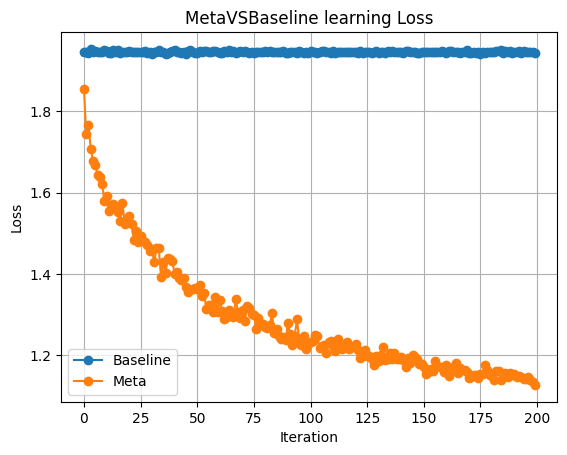

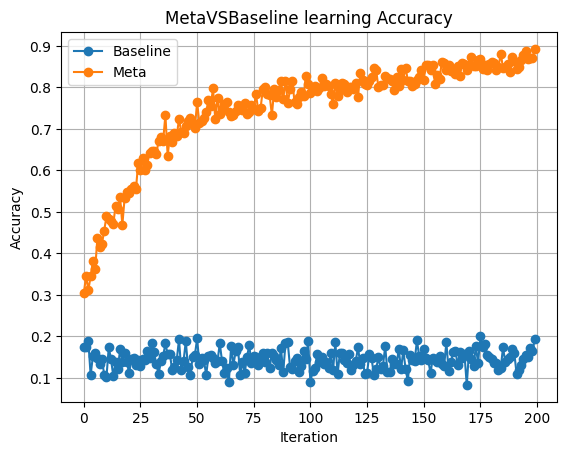

In [62]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_baseline["iteration"], df_baseline["loss"], marker='o', label="Baseline")
plt.plot(df_meta["iteration"], df_meta["loss"], marker='o', label="Meta")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("MetaVSBaseline learning Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(df_baseline["iteration"], df_baseline["accuracy"], marker='o', label="Baseline")
plt.plot(df_meta["iteration"], df_meta["accuracy"], marker='o', label="Meta")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("MetaVSBaseline learning Accuracy")
plt.grid(True)
plt.legend()
plt.show()

Так же видно что meta learning хорошо помогает при задачах классифкации.

Конечно meta learning лучше применим к дообучению, а не обученю с нуля. Но нужно было просто быстро сравнить и попрактиковаться